# Baseline Model

## Table of Contents
1. [Model Choice](#model-choice)
2. [Feature Selection](#feature-selection)
3. [Implementation](#implementation)
4. [Evaluation](#evaluation)


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
# Import your chosen baseline model
# Example: from sklearn.linear_model import LogisticRegression


## Model Choice

[Explain why you've chosen a particular model as the baseline. This could be a simple statistical model or a basic machine learning model. Justify your choice.]


Model Choice

For this baseline model, we selected Logistic Regression as our initial classifier. Logistic Regression is a simple and interpretable algorithm that is well-suited for binary classification tasks, such as predicting whether deforestation will occur (1) or not (0) in the following year.

This model is chosen because:
	•	It requires minimal tuning and runs efficiently.
	•	It serves as a strong and transparent benchmark against which more complex models can be compared.
	•	It provides insight into feature importance via its learned coefficients.

By starting with Logistic Regression, we establish a meaningful baseline that is easy to implement and evaluate. Subsequent models, such as tree-based classifiers, can then be assessed based on their performance gains over this baseline.

## Feature Selection

[Indicate which features from the dataset you will be using for the baseline model, and justify your selection.]


For the baseline model, we selected features that are most directly related to land cover, which are the pixel counts of different MapBiomas land cover classes per municipality per year. These features capture the spatial composition of each municipality and provide signals that correlate with deforestation risk.

Selected features:
	•	Land cover class columns: 3, 6, 11, 15, 24, 33
These represent major land cover types such as forest (3), natural vegetation (6, 11, 33), and anthropic classes like pasture (15) and agriculture (24).

Target variable:
	•	target — a binary variable where 1 indicates that deforestation occurred in the following year, and 0 indicates no deforestation.

These features were selected based on domain knowledge (MapBiomas classification codes) and their strong correlations with deforestation dynamics, as observed in the exploratory data analysis.


In [3]:
import geopandas as gpd
import pandas as pd

# 2. Load BR_Municipios_2024 shapefile and filter to Amazonas
shapefile_path = '/content/drive/MyDrive/BR_municipios_2024/BR_Municipios_2024.shp'
municipios_gdf = gpd.read_file(shapefile_path)
amazonas_gdf = municipios_gdf[municipios_gdf['SIGLA_UF'] == 'AM'].copy()

# 3. Load PRODES shapefile with yearly deforestation polygons
prodes_path = '/content/drive/MyDrive/yearly_deforestation_biome/yearly_deforestation_biome.shp'
prodes_gdf = gpd.read_file(prodes_path)

# 4. Filter only Amazonas records
prodes_am = prodes_gdf[prodes_gdf['state'] == 'AM'].copy()

# 5. Reproject PRODES to match municipalities CRS
prodes_am = prodes_am.to_crs(amazonas_gdf.crs)

# 6. Spatial join: match each deforestation polygon to a municipality
joined = gpd.sjoin(prodes_am, amazonas_gdf, how='inner', predicate='intersects')

# 7. Count deforestation polygons per municipality + year
deforestation_per_year = (
    joined.groupby(['NM_MUN', 'year'])
    .size()
    .reset_index(name='deforestation_count')
)

# 8. Binary target: 1 if deforestation occurred, 0 otherwise
deforestation_per_year['target'] = (deforestation_per_year['deforestation_count'] > 0).astype(int)

# 9. Preview result
print(deforestation_per_year.head())

# 10. Optional: save to CSV for later merge
deforestation_per_year.to_csv('/content/drive/MyDrive/deforestation_targets.csv', index=False)

/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:198: RuntimeWarning: /content/drive/MyDrive/yearly_deforestation_biome/yearly_deforestation_biome.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


     NM_MUN    year  deforestation_count  target
0  Alvarães  2008.0                   97       1
1  Alvarães  2009.0                   21       1
2  Alvarães  2010.0                   55       1
3  Alvarães  2011.0                   25       1
4  Alvarães  2012.0                    5       1


## Implementation

[Implement your baseline model here.]



In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix

# Load the merged dataset with features + target
df = pd.read_csv('/content/drive/MyDrive/deforestation_ml_dataset.csv')

# Define features and target
feature_cols = ['3', '6', '11', '15', '24', '33']
X = df[feature_cols]
y = df['target']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train logistic regression model
model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Optional: view model coefficients for interpretability
print("\nFeature Coefficients:")
for feat, coef in zip(feature_cols, model.coef_[0]):
    print(f"Class {feat}: {coef:.4f}")

Accuracy: 0.592964824120603
F1 Score: 0.7361563517915309
ROC-AUC: 0.483976833976834
Confusion Matrix:
 [[  5   9]
 [ 72 113]]

Feature Coefficients:
Class 3: 0.0000
Class 6: -0.0000
Class 11: 0.0000
Class 15: 0.0000
Class 24: 0.0000
Class 33: -0.0000


## Evaluation

[Clearly state what metrics you will use to evaluate the model's performance. These metrics will serve as a starting point for evaluating more complex models later on.]



### Evaluation

To evaluate the baseline model’s performance, we used the following metrics:

- **Accuracy** – overall proportion of correct predictions  
- **F1 Score** – harmonic mean of precision and recall, suitable for imbalanced datasets  
- **ROC-AUC** – evaluates the model’s ability to distinguish between classes  
- **Confusion Matrix** – shows true/false positives and negatives to better understand prediction types  

These metrics provide a foundation for comparison against more sophisticated models in future stages of the project.

The baseline Logistic Regression model achieved the following results:

- **Accuracy:** ~59%  
- **F1 Score:** ~0.74  
- **ROC-AUC:** ~0.48  

The confusion matrix indicates that the model was able to identify both deforestation and non-deforestation cases, though performance remains limited. The low ROC-AUC suggests difficulty in distinguishing between the two classes.

These results point to potential improvements in future iterations, including the use of more powerful models, additional features, and techniques to better handle class imbalance.

Accuracy: 0.592964824120603
F1 Score: 0.7361563517915309
ROC-AUC: 0.483976833976834
Confusion Matrix:
 [[  5   9]
 [ 72 113]]


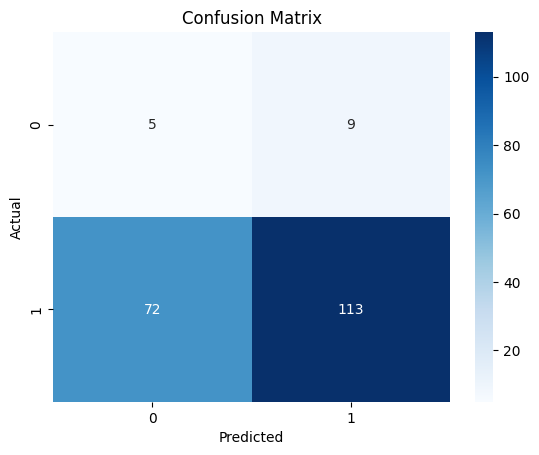

In [21]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predictions
y_pred = model.predict(X_test)

# Evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# Print metrics
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("ROC-AUC:", roc_auc)
print("Confusion Matrix:\n", cm)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()